In [1]:
!module purge
!module load apps/anaconda3
!module load compilers/nvidia/cuda/11.2
!module load compilers/gcc/8.3.0

In [2]:

import cv2
import os
import random

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline

In [4]:
import tensorflow as tf
import tensorflow.keras as keras


In [5]:
tf.__version__

'2.7.0'

In [6]:
tf.random.set_seed(42)
np.random.seed(42)


In [7]:
train_dir = "/home/191112024/splited_dataset/AGCCPF/train"
test_dir = "/home/191112024/splited_dataset/AGCCPF/test"
valid_dir = "/home/191112024/splited_dataset/AGCCPF/validate"


In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=True
        )

valid_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=True
        )

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=False
        )

Found 5253 images belonging to 3 classes.
Found 1315 images belonging to 3 classes.
Found 1644 images belonging to 3 classes.


In [11]:
from tensorflow.keras import optimizers

In [12]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, DepthwiseConv2D
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
# Creating Densenet121
def densenet(x, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    

    
    for repetition in [6,12,24,16]:
    # for repetition in [6,12,24]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
        
    return d


def VGG16(x):
    x=Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    x=Conv2D(filters=128,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=Conv2D(filters=128,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    x=Conv2D(filters=256,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=Conv2D(filters=256,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=Conv2D(filters=256,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    x=Conv2D(filters=512,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=Conv2D(filters=512,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=Conv2D(filters=512,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    x=Conv2D(filters=512,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=Conv2D(filters=512,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=Conv2D(filters=512,kernel_size=(3,3),padding="same",activation="relu")(x)
    x=MaxPool2D(pool_size=(2,2),strides=(2,2))(x)

    return x

input_shape = 224, 224, 3
n_classes = 3
input_ = Input (input_shape)
x = Conv2D(64, 7, strides = 2, padding = 'same')(input_)
x = MaxPool2D(3, strides = 2, padding = 'same')(x)
densenet_layer = densenet(x)
vGG16_layer=VGG16(x)

densenet_layer = GlobalAveragePooling2D()(densenet_layer)
vGG16_layer=GlobalAveragePooling2D()(VGG16_layer)

merge=concatenate([densenet_layer,VGG16_layer])

output = Dense(n_classes, activation = 'softmax')(merge)
model=Model(input_,output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [14]:
%cd /content/gdrive/MyDrive/

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/'
/home/191112024


In [15]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "model_23.h5", save_best_only=True)
earlystop_cb = keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True)


In [16]:
history = model.fit(train_generator,
                    steps_per_epoch=250,
                    epochs=300,
                    validation_data=valid_generator,
                    validation_steps=60,
                    callbacks=[checkpoint_cb])


Epoch 1/300
250/250 [==============================] - ETA: 0s - loss: 0.9908 - acc: 0.5123 - recall: 0.3781 - precision: 0.5365

/home/191112024/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


250/250 [==============================] - 514s 2s/step - loss: 0.9908 - acc: 0.5123 - recall: 0.3781 - precision: 0.5365 - val_loss: 1.1634 - val_acc: 0.1858 - val_recall: 0.0033 - val_precision: 0.3636
Epoch 2/300
250/250 [==============================] - 490s 2s/step - loss: 0.9637 - acc: 0.5277 - recall: 0.4036 - precision: 0.5533 - val_loss: 1.0618 - val_acc: 0.3925 - val_recall: 0.0583 - val_precision: 0.4023
Epoch 3/300
250/250 [==============================] - 494s 2s/step - loss: 0.9466 - acc: 0.5396 - recall: 0.4232 - precision: 0.5672 - val_loss: 1.0008 - val_acc: 0.5317 - val_recall: 0.2258 - val_precision: 0.5766
Epoch 4/300
250/250 [==============================] - 487s 2s/step - loss: 0.9444 - acc: 0.5466 - recall: 0.4194 - precision: 0.5721 - val_loss: 1.0871 - val_acc: 0.5367 - val_recall: 0.5233 - val_precision: 0.5409
Epoch 5/300
250/250 [==============================] - 491s 2s/step - loss: 0.9274 - acc: 0.5500 - recall: 0.4328 - precision: 0.5814 - val_loss: 1.

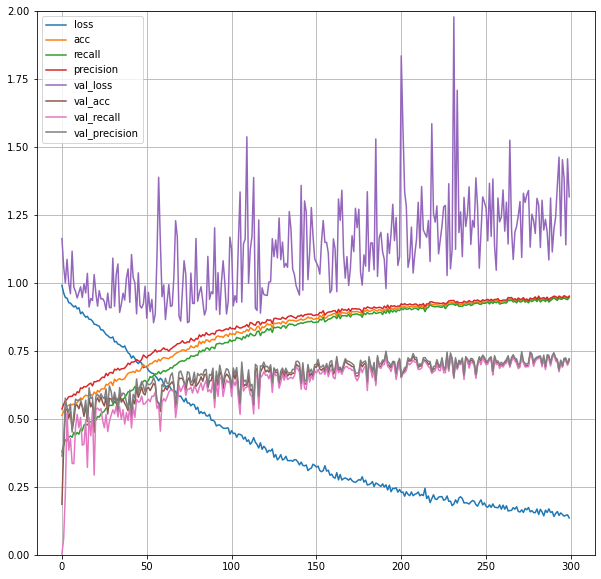

In [17]:
pd.DataFrame(history.history).plot(figsize=(10, 10))
plt.ylim((0,2))
plt.grid(True)
plt.show()

In [18]:
model.evaluate(test_generator)

83/83 [==============================] - 22s 258ms/step - loss: 1.2352 - acc: 0.7117 - recall: 0.7080 - precision: 0.7163


[1.2351776361465454,
 0.7116788029670715,
 0.7080292105674744,
 0.7163076996803284]

In [19]:
x=model.predict(train_generator)
actual=train_generator.labels
pred=np.argmax(x, axis=-1)
from sklearn.metrics import confusion_matrix
confusion_matrix(actual,pred)

array([[ 149,  480,  292],
       [ 473, 1402,  905],
       [ 260,  782,  510]])

In [20]:
x=model.predict(valid_generator)
actual=valid_generator.labels
pred=np.argmax(x, axis=-1)
from sklearn.metrics import confusion_matrix
confusion_matrix(actual,pred)

array([[ 35, 104,  92],
       [ 91, 308, 297],
       [ 65, 160, 163]])

In [21]:
x=model.predict(test_generator)
actual=test_generator.labels
pred=np.argmax(x, axis=-1)
from sklearn.metrics import confusion_matrix
confusion_matrix(actual,pred)

array([[ 50, 118, 120],
       [119, 393, 358],
       [ 72, 205, 209]])